In [23]:
import sys
sys.path.append("/scratch/cvlab/home/afan/projects/disk")

from disk.data import get_datasets2
import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
from einops import (rearrange, reduce, repeat)

In [24]:
data_path = "/scratch/cvlab/datasets/dataset_DISK"
batch_size = 2
train_scene_limit = 1000
test_scene_limit = 250
height = 512
width = 512

In [25]:
train_dataloader, test_dataloader = get_datasets2(
    data_path,
    no_depth=False,
    batch_size=batch_size,
    train_limit=train_scene_limit,
    test_limit=test_scene_limit,
    crop_size=(height, width),
)
DEV = torch.device('cuda')
print(train_dataloader)

In [26]:
print(len(train_dataloader))
print(len(test_dataloader))
H, W = (512, 512)
x_ref, y_ref = torch.meshgrid(torch.arange(0, W), torch.arange(0, H))
grid_samples = rearrange(torch.stack([x_ref, y_ref]), 'c H W -> c (H W)').to(DEV, non_blocking=True)

67500
375


In [27]:
for i, batch in enumerate(train_dataloader):
    bitmaps, images = batch.to(DEV, non_blocking=True)
    for j in range(bitmaps.shape[0]):
        bitmap_0 = bitmaps[j, 0]
        image_0 = images[j, 0]
        bitmap_1 = bitmaps[j, 1]
        image_1 = images[j, 1]
        reprojections = image_1.project(image_0.unproject(grid_samples))
    break

In [28]:
def sanity_check(kps1, kps2, img1, img2):
    # reproject to the other image.
    kps1_r = img2.project(img1.unproject(kps1)) # [2, N]
    kps2_r = img1.project(img2.unproject(kps2)) # [2, N]

    # compute pixel-space differences between (kp1, repr(kp2))
    # and (repr(kp1), kp2)
    diff1 = kps2_r - kps1# [2, N]
    diff2 = kps1_r - kps2 # [2, N]

    print(diff1)
    print(diff1.shape)
    print(diff2.shape)

    # NaNs indicate we had no depth available at this location
    has_depth = (torch.isfinite(diff1) & torch.isfinite(diff2)).all(dim=0)

    # threshold the distances
    close1 = torch.norm(diff1, p=2, dim=0) < 2.0
    close2 = torch.norm(diff2, p=2, dim=0) < 2.0

    good_pairs = close1 & close2

    return good_pairs

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')
torch.Size([2, 262144])
torch.Size([2, 262144])


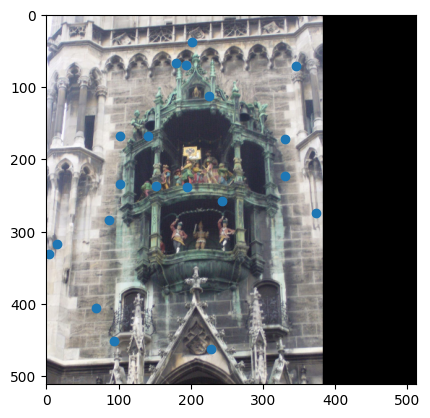

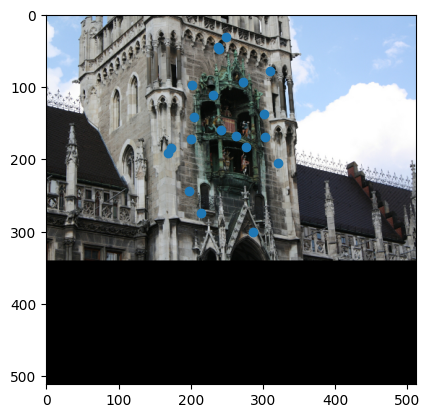

In [31]:
flag = sanity_check(grid_samples, reprojections, image_0, image_1)
pts_0 = grid_samples[:, flag]
pts_1 = reprojections[:, flag]

num_sample = 20
sample = np.random.choice(range(pts_0.shape[1]), num_sample)
pts_0 = pts_0[:, sample]
pts_1 = pts_1[:, sample]

plt.figure()
plt.imshow(bitmap_0.permute(1,2,0).cpu().numpy())
plt.scatter(pts_0[0].cpu().numpy(), pts_0[1].cpu().numpy())
plt.show()


plt.figure()
plt.imshow(bitmap_1.permute(1,2,0).cpu().numpy())
plt.scatter(pts_1[0].cpu().numpy(), pts_1[1].cpu().numpy())
plt.show()